Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  1.1.0
torch:  1.6.0
numpy:  1.19.1


In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

In [3]:
khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

sys.path.insert(1, khs_dir)
import helperFuncs as funcH

def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    uniq_pred_ids = np.unique(pred_vec)
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn, uniq_pred_ids

funcH.setPandasDisplayOpts()

# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /media/wsubuntu/SSD_Data/DataPath
wsubuntu_experiment_path = /media/wsubuntu/SSD_Data/vaesae_experiments
cpu


Constructing the Argument Parsers

In [4]:
EXPERIMENT_ID = 41
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'batchmean','sum'
LOSS_ACT='sigmoid'
APPLY_LOG_SOFTMAX=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

epochs = 30  # args['epochs']
REG_PARAM = 0.0001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(root=FOLDERS["data"], train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=FOLDERS["data"],train=False,download=True,transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type, enc_loss_act):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.enc_loss_act=enc_loss_act
        self.device = get_device()
        print("SparseAutoencoder - loss_type(" + loss_type +"), enc_loss_act(" + enc_loss_act +"), device(" + self.device + ")")

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        if self.enc_loss_act=='sigmoid':
            bottleneck = torch.sigmoid(self.enc5(x))
        else:#relu
            bottleneck = F.relu(self.enc5(x))  
        
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE, enc_loss_act=LOSS_ACT).to(device)

SparseAutoencoder - loss_type(cre), enc_loss_act(sigmoid), device(cpu)


In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    _, preds = torch.max(bottleneck, 1)
    if print_info:
        print("apply_log_softmax:",apply_log_softmax)
        print("bottleneck in :",bottleneck)

    if apply_log_softmax:
        loss_ret_1 = loss_fun(F.log_softmax(bottleneck, dim=1).to(device), preds)
    else:
        loss_ret_1 = loss_fun(bottleneck.to(device), preds)
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print("bottleneck out:",bottleneck)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - REG_PARAM * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + REG_PARAM * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df, uniq_pred_ids

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df, uniq_pred_ids

In [13]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_ACT : ", LOSS_ACT)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("APPLY_LOG_SOFTMAX : ", APPLY_LOG_SOFTMAX)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param(" + "{:.5f}".format(REG_PARAM) + ") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr, uniq_pred_ids_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va, uniq_pred_ids_va = validate(model, testloader, epoch, print_losses_fit)
    print("uniq_pred_ids_tr:", uniq_pred_ids_tr)
    print("uniq_pred_ids_va:", uniq_pred_ids_va)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time() 
print(f"{(end-start)/60:.3} minutes")
mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws :: 
EXPERIMENT_ID:  41
LOSS_TYPE :  cre
LOSS_ACT :  sigmoid
LOSS_REDUCTION :  mean
APPLY_LOG_SOFTMAX :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.00010) * sp_loss
*****
 Epoch 0 of 30
TrEpoch(000) - apply_log_softmax: True
bottleneck in : tensor([[0.4835, 0.5473, 0.5256,  ..., 0.4508, 0.5277, 0.4659],
        [0.4837, 0.5484, 0.5237,  ..., 0.4518, 0.5265, 0.4648],
        [0.4828, 0.5481, 0.5233,  ..., 0.4516, 0.5275, 0.4641],
        ...,
        [0.4835, 0.5476, 0.5242,  ..., 0.4509, 0.5272, 0.4647],
        [0.4833, 0.5484, 0.5234,  ..., 0.4514, 0.5280, 0.4645],
        [0.4824, 0.5471, 0.5235,  ..., 0.4516, 0.5279, 0.4640]],
       grad_fn=<SigmoidBackward>)
bottleneck out: tensor([[0.4835, 0.5473, 0.5256,  ..., 0.4508, 0.5277, 0.4659],
        [0.4837, 0.5484, 0.5237,  ..., 0.4518, 0.5265, 0.4648],
        [0.4828, 0.5481, 0.5233,  ..., 0.4516, 0.5275, 0.4641],
        ...,
        [0.4835, 0.5476, 0.5242,  ..., 0.4509, 0.5272, 0.4647],
     


       acc  bmx    bmn     mse       spr     run
0  11.238  1.0  0.009  56.559  5633.352  57.122
ValEpoch(016) - 
      acc  bmx    bmn    run
0  11.17  1.0  0.008  9.326
uniq_pred_ids_tr: [ 2  5 19 20 23]
uniq_pred_ids_va: [ 2  5 19 20]
*****
 Epoch 17 of 30
TrEpoch(017) - 
       acc  bmx    bmn     mse       spr     run
0  11.213  1.0  0.009  55.024  5632.311  55.587
ValEpoch(017) - 
      acc  bmx    bmn    run
0  10.96  1.0  0.009  9.181
uniq_pred_ids_tr: [ 2  5 19 20 23]
uniq_pred_ids_va: [ 2  5 19 20]
*****
 Epoch 18 of 30
TrEpoch(018) - 
       acc  bmx    bmn    mse      spr     run
0  11.122  1.0  0.008  54.41  5631.86  54.974
ValEpoch(018) - 
      acc  bmx    bmn    run
0  11.05  1.0  0.009  9.112
uniq_pred_ids_tr: [ 2  5 19 20 23]
uniq_pred_ids_va: [ 2  5 19 20]
*****
 Epoch 19 of 30
TrEpoch(019) - 
       acc  bmx    bmn     mse       spr     run
0  11.078  1.0  0.009  54.136  5631.569  54.699
ValEpoch(019) - 
      acc  bmx    bmn    run
0  10.94  1.0  0.009  9.067
uniq

In [14]:
print(result_df_tr_all)

       acc  bmx        bmn      mse       spr      run
0   18.352  1.0  2.429e-04  170.763  5950.176  171.358
1   13.217  1.0  9.268e-03  106.442  5805.040  107.023
2   13.395  1.0  9.215e-03   85.098  5733.173   85.672
3   10.578  1.0  1.300e-02   78.099  5703.886   78.669
4   10.535  1.0  1.555e-02   75.037  5691.852   75.606
5   10.545  1.0  1.773e-02   73.929  5683.827   74.497
6   10.475  1.0  1.640e-02   71.412  5677.479   71.980
7   11.020  1.0  1.850e-02   68.299  5669.567   68.866
8   11.017  1.0  1.160e-02   66.618  5661.744   67.184
9   11.173  1.0  1.332e-02   65.101  5656.771   65.667
10  11.700  1.0  1.671e-02   63.256  5653.009   63.821
11  11.883  1.0  1.567e-02   61.466  5648.311   62.031
12  11.727  1.0  1.245e-02   60.420  5643.666   60.984
13  11.470  1.0  9.405e-03   59.312  5639.664   59.876
14  11.347  1.0  8.955e-03   57.962  5636.329   58.525
15  11.302  1.0  9.149e-03   57.514  5635.147   58.077
16  11.238  1.0  8.645e-03   56.559  5633.352   57.122
17  11.213

In [15]:
print(result_df_va_all)

      acc    bmx    bmn     run
0   18.49  0.996  0.016  20.088
1   16.49  1.000  0.011  15.255
2   10.84  1.000  0.014  13.576
3   10.52  1.000  0.018  12.814
4   10.62  1.000  0.019  12.441
5   10.26  1.000  0.017  12.280
6   10.71  1.000  0.019  11.674
7   10.88  1.000  0.025  11.231
8   10.82  1.000  0.025  11.111
9   11.55  1.000  0.026  10.708
10  11.74  1.000  0.020  10.482
11  11.82  1.000  0.016  10.168
12  11.33  1.000  0.014   9.987
13  11.34  1.000  0.011   9.864
14  11.23  1.000  0.009   9.703
15  11.04  1.000  0.011   9.604
16  11.17  1.000  0.008   9.326
17  10.96  1.000  0.009   9.181
18  11.05  1.000  0.009   9.112
19  10.94  1.000  0.009   9.067
20  11.04  1.000  0.010   8.972
21  10.97  1.000  0.011   8.904
22  10.56  1.000  0.015   8.826
23  10.48  1.000  0.013   8.774
24  10.45  1.000  0.015   8.632
25  10.43  1.000  0.017   8.552
26  10.39  1.000  0.015   8.501
27  10.53  1.000  0.014   8.410
28  10.58  1.000  0.015   8.384
29  10.69  1.000  0.015   8.341


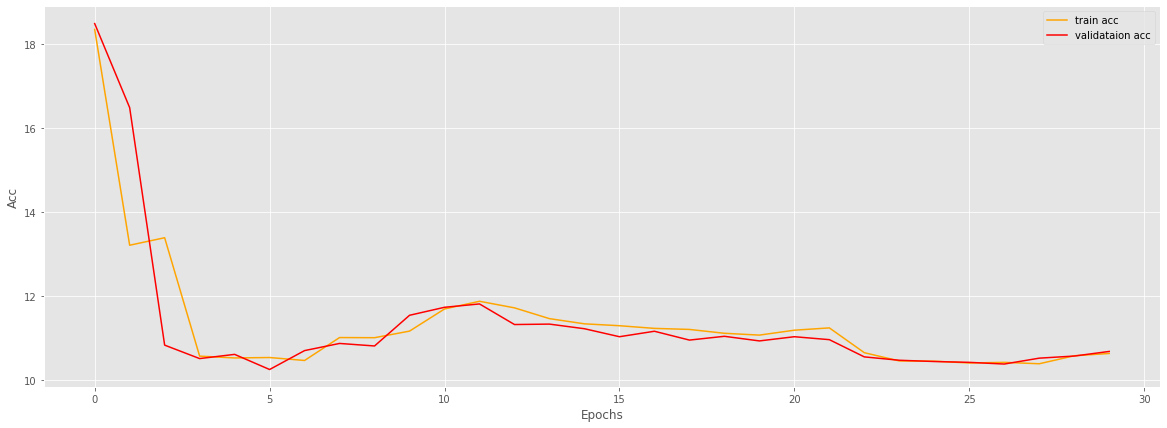

Max tr acc =  18.351666666666667
Max va acc =  18.49


In [16]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

all(5950.18), trmse(34.00), trspr(1.00), vaerr(296.00)


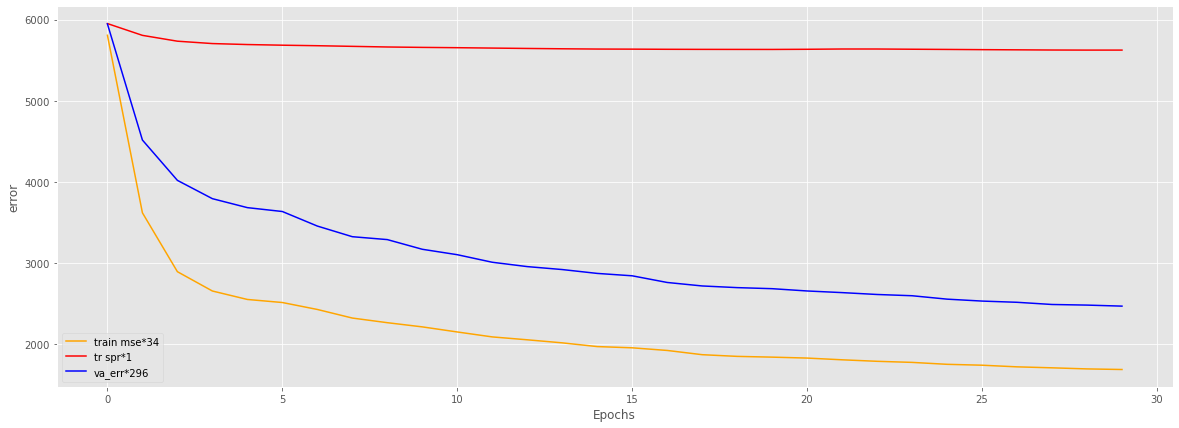

In [17]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr = result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()

mx_all = np.max([tr_mse, tr_spr, va_err])
tr_mse_mul = int(mx_all/np.max(tr_mse))
tr_spr_mul = int(mx_all/np.max(tr_spr))
va_err_mul = int(mx_all/np.max(va_err))
print("all({:.2f}), trmse({:.2f}), trspr({:.2f}), vaerr({:.2f})".format(mx_all, tr_mse_mul, tr_spr_mul, va_err_mul))

plt.figure(figsize=(20, 7))
plt.plot(tr_mse*tr_mse_mul, color='orange', label='train mse*'+str(tr_mse_mul))
plt.plot(tr_spr*tr_spr_mul, color='red', label='tr spr*'+str(tr_spr_mul))
plt.plot(va_err*va_err_mul, color='blue', label='va_err*'+str(va_err_mul))
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()